## 0. Import statements

In [1]:
import sbmlnetwork
import libsbml

import pandas as pd
import tellurium as te
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import re

In [2]:
rxns = pd.read_csv('src/frenda_brenda/Files/KEGG_Filtered/Reactions_M0.csv')

## 1. Retrieve coordinates from KEGG
### 1a. Get the (x,y) coordinates for each species in the KEGG map

In [3]:
def get_kegg_orthology_ids(reaction_ids):
    orthology_dict = {}
    for reaction_id in reaction_ids:
        url = f"https://www.kegg.jp/dbget-bin/www_bget?rn:{reaction_id}"
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')

        # Find the orthology section
        orthology_section = soup.find('th', string="Orthology")
        if orthology_section:
            # Get the orthology ID from the adjacent <td> tag
            orthology_ids = orthology_section.find_next('td').find_all('a')
            # Filter IDs that start with 'K'
            orthology_dict[reaction_id] = [ortho_id.get_text() for ortho_id in orthology_ids if ortho_id.get_text().startswith('K')]
        else:
            orthology_dict[reaction_id] = []
    
    return orthology_dict

In [4]:
orthology_ids = get_kegg_orthology_ids(rxns['Reaction ID'])

In [5]:
import xml.etree.ElementTree as ET
from Bio.KEGG.KGML import KGML_parser
from Bio.Graphics.KGML_vis import KGMLCanvas

def map_reaction_to_entry_id(xml_file_path, reaction_orthology_dict):
    # Parse the XML file
    pathway = KGML_parser.read(open(xml_file_path, 'r'))

    # Initialize dictionary to hold the reaction ID -> entry ID mapping
    reaction_entry_map = {}

    # Loop through each entry in the pathway
    for entry in pathway.entries.values():
        # Check if the entry is of type 'ortholog'
        if entry.type == "ortholog":
            # Extract the orthology IDs (split by space, remove 'ko:' prefix)
            orthology_ids_in_entry = entry.name.replace('ko:', '').split()

            # Convert to set for comparison
            orthology_ids_in_entry_set = set(orthology_ids_in_entry)

            # Loop through the reaction dictionary
            for reaction_id, orthology_ids in reaction_orthology_dict.items():
                if len(orthology_ids)==0:
                    continue
                # Convert orthology_ids from the reaction dictionary to a set
                orthology_ids_set = set(orthology_ids)

                # Check if all orthology IDs in the entry are present in orthology_ids_set
                # CHANGING THIS AS AN EXPERIMENT: CHECK IF ANY OF THE ORTHOLOGY IDS IN THE ENTRY ARE PRESENT IN ORTHOLOGY_IDS_SET
                # if not orthology_ids_set.isdisjoint(orthology_ids_in_entry_set):
                # if orthology_ids_set.issubset(orthology_ids_in_entry_set):
                if not orthology_ids_set.isdisjoint(orthology_ids_in_entry_set):
                    # Add the mapping to the dictionary
                    if reaction_id not in reaction_entry_map:
                        reaction_entry_map[reaction_id] = []
                    reaction_entry_map[reaction_id].append(entry.id)  # Save the entry ID

    return reaction_entry_map

In [6]:
xml_file = 'ko01100.xml'
reaction_entry_map = map_reaction_to_entry_id(xml_file, orthology_ids)

In [7]:
pathway = KGML_parser.read(open(xml_file, 'r'))
reaction_dict = reaction_entry_map
    
# Initialize dictionary to hold the cpd ID and Reaction ID mapping
cpd_coordinates_map = {}

# Loop through the reaction dictionary
for reaction_id, entry_ids in reaction_dict.items():
    for entry_id in entry_ids:
        # Search for the reaction in the pathway
        reaction_entry = next((reaction for reaction in pathway.reactions if reaction.id == entry_id), None)

        if reaction_entry:
            newrns = []
            for rn in reaction_entry._names:
                newrns.append(rn.replace('rn:',''))
            if reaction_id in newrns:
                # Collect substrates
                sloop_counter = 0
                for substrate in reaction_entry._substrates:
                    substrate_entry = next((sub for sub in pathway.entries.values() if sub.id == substrate), None)
                    x, y = substrate_entry.graphics[0].x, substrate_entry.graphics[0].y
                    
                    rxnentry = str(reaction_entry)
                    # Split the string into lines and find the line containing 'Substrates'
                    substrates_line = next(line for line in rxnentry.splitlines() if 'Substrates:' in line)
                    # Extract the part of the line after 'Substrates:'
                    substrates_part = substrates_line.split('Substrates: ')[1]
                    # Split the substrates by comma and strip the 'cpd:' prefix
                    cpd_id = [substrate.strip().replace('cpd:', '') for substrate in substrates_part.split(',')][sloop_counter]
                    sloop_counter += 1

                    cpd_coordinates_map[f"{cpd_id}_{reaction_id}_{entry_id}"] = (x, y)

                # Collect products
                ploop_counter = 0
                for product in reaction_entry._products:
                    product_entry = next((prod for prod in pathway.entries.values() if prod.id == product), None)
                    x, y = product_entry.graphics[0].x, product_entry.graphics[0].y
                    
                    rxnentry = str(reaction_entry)
                    # Split the string into lines and find the line containing 'Substrates'
                    products_line = next(line for line in rxnentry.splitlines() if 'Products:' in line)
                    # Extract the part of the line after 'Substrates:'
                    products_part = products_line.split('Products: ')[1]
                    # Split the substrates by comma and strip the 'cpd:' prefix
                    cpd_id = [product.strip().replace('cpd:', '') for product in products_part.split(',')][ploop_counter]
                    ploop_counter += 1

                    cpd_coordinates_map[f"{cpd_id}_{reaction_id}_{entry_id}"] = (x, y)

In [8]:
data = pd.read_csv('/workspaces/ECFERS/kegg_labels_add.csv',dtype='str',encoding='us-ascii',encoding_errors='ignore')
data = data.where(data.notnull(), None)

In [9]:
# Create a new dictionary with replaced keys
cpd_coordinates_map_tran = {}
for key, value in cpd_coordinates_map.items():
    new_key = key
    # Check for each "KEGG ID" in the key string
    for _, row in data.iterrows():
        kegg_id = row['KEGG ID']
        id_value = row['ID']
        # Replace any occurrence of the "KEGG ID" within the key string
        if kegg_id in new_key:
            new_key = new_key.replace(kegg_id, id_value)
    # Add the modified key-value pair to the new dictionary
    cpd_coordinates_map_tran[new_key] = value

## 2. Apply KEGG coordinates to SBMLNetwork layout
## You can ignore all of this and just run the final cell to load the SBML model

### 2a. Translate the antimony file with KEGG compound IDs to have human readable names. Then, build an SBML file from this translated antimony file. Use libSBML to add in display names and annotations.

Read in the KEGG translation file. Only run the first code block if you need to regenerate the translation file with code complacent IDs.

In [39]:
data = pd.read_csv('/workspaces/ECFERS/kegg_labels.csv',dtype='str',encoding='us-ascii',encoding_errors='ignore')
data = data.where(data.notnull(), None)

def clean_string(s):
    # Remove unwanted characters
    cleaned = re.sub(r"[-,+,\'\[\]\(\)\s]", "", s)
    # If the string starts with a digit, add an underscore at the beginning
    if cleaned[0].isdigit():
        cleaned = f"_{cleaned}"
    return cleaned

# Apply the function to the second column and create a new column with the result
data['ID'] = data.iloc[:, 1].apply(clean_string)

data.to_csv('/workspaces/ECFERS/kegg_labels_add.csv')

In [40]:
data

,KEGG ID,Label,ID
0,C00354,FBP,FBP
1,C05345,b-F6P,bF6P
2,C00092,G6P,G6P
3,C00103,a-G1P,aG1P
4,C00042,Succinate,Succinate
...,...,...,...
920,C05263,3-Oxododecanoyl-CoA,_3OxododecanoylCoA
921,C16339,(+)-7-Isojasmonic acid CoA,_7IsojasmonicacidCoA
922,C00249,Hexadecanoic acid,Hexadecanoicacid
923,C11165,Thiolactomycin,Thiolactomycin


In [41]:
data = pd.read_csv('/workspaces/ECFERS/kegg_labels_add.csv',dtype='str',encoding='us-ascii',encoding_errors='ignore')
data = data.where(data.notnull(), None)

In [ ]:
# Load the text file. Change this string to reflect whichever antimony file you want to translate.
with open('/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0.txt', 'r') as file:
    text = file.read()

# Replace each "KEGG ID" in the text with the corresponding "ID"
for _, row in data.iterrows():
    kegg_id = row['KEGG ID']
    id_value = row['ID']
    text = text.replace(str(kegg_id), str(id_value))

# Save the modified text to a new file. Update this string to reflect your naming convention.
with open('/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0_renamed.txt', 'w') as file:
    file.write(text)

We now have a translated antimony file and SBML file. We need to use the KEGG labels Rosetta stone to add in the display names and annotations to the SBML file.

In [43]:
# Read the existing file
with open('/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0_renamed.txt', 'r') as file:
    content = file.readlines()

In [ ]:
from equilibrator_api import ComponentContribution
cc = ComponentContribution()

ASSUMPTIONS:
Antimony file must be functional and can be converted to SBML and simulated with roadrunner

METHOD:
Ask which databases the user would like to annotate with.
Turn Antimony file into SBML file.
Simulate SBML file with RoadRunner.
Grab stoichiometry matrix from RoadRunner.
Save all metabolites to a list.
For each metabolite in that list, search it using equilibrator's component contribution.
Grab the IDs for annotating from each available and desired database.
Write a line for that annotation at the tail of the Antimony file.

ALTERNATIVE:

ASSUMPTIONS:
Antimony file contains no reactions which have a metabolite on both sides of the equation.
Antimony file has all species defined initially.

METHOD:
Ask which databases the user would like to annotate with.
Parse the Antimony file for all species definitions.
Parse the Antimony file for enzymes by determining what is the same on both sides of the chemical reaction.
Subtract enzymes from list of species to obtain exclusively metabolites.
For each metabolite in that list, search it using equilibrator's component contribution.
Grab the IDs for annotating from each available and desired database.
Write a line for that annotation at the tail of the Antimony file.

In [ ]:
# diego had a good idea, can try to use the stoichiometry matrix to grab the metabolites

for line in content:
    # this isn't even totally right because there can be other things defined in species, like enzymes
    # how do we make a way to be able to tell what is actually a species?
    if line.startswith('species'):
        print(line.split(' ')[1][:-2])

H2O
DEPC
Cyanideion
NH3
HCN
HCl
CO2
Oxalate
Azide
NAD
Dha
CoA
Oxa
Pyr
Serine
Formate
AcCoA
PO4
Diacetyl
Mal
EDTA
ADP
NADH
H
Chloride
_2OxoAc
NEthylmaleimide
aAAc
ATP
Oxygen
C00088
C00244
C01417
eEC11137
hEC11137
hEC43117
hEC6411
hEC11719


In [ ]:
# thinking about how to turn this function I wrote into a pip library
# we used a handcrafted CSV to convert from our ID names to the KEGG IDs, but not everybody will use our ID names, so we can't use that
# we might be able to use equilibrator's cc to search them, and then grab a whole bunch of different ID's, but it'll be slow

# YOU CAN ONLY USE THIS IF YOU INITIALIZE YOUR SPECIES AT THE BEGINNING
for i in cc.search_compound(compound[0]).identifiers:
                    if i.registry.namespace == 'kegg':
                        keggid = i.accession
                        compound_dict[compound[0]] = keggid

,Unnamed: 0,KEGG ID,Label,ID
0,0,C00354,FBP,FBP
1,1,C05345,b-F6P,bF6P
2,2,C00092,G6P,G6P
3,3,C00103,a-G1P,aG1P
4,4,C00042,Succinate,Succinate
...,...,...,...,...
920,920,C05263,3-Oxododecanoyl-CoA,_3OxododecanoylCoA
921,921,C16339,(+)-7-Isojasmonic acid CoA,_7IsojasmonicacidCoA
922,922,C00249,Hexadecanoic acid,Hexadecanoicacid
923,923,C11165,Thiolactomycin,Thiolactomycin


In [ ]:
# Read the existing file
with open('/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0_renamed.txt', 'r') as file:
    content = file.readlines()

# Append lines to the file based on data in your DataFrame, only if id_value exists in content
with open('/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0_renamed.txt', 'a') as file:
    file.write(f'\n')  # Add a newline before appending new content
    for _, row in data.iterrows():
        kegg_id = row['KEGG ID']
        label = row['Label']
        id_value = row['ID']

        # Check if id_value appears in the existing content
        if any(id_value in line for line in content):
            # Write each new line to the file
            file.write(f'{id_value} is "{label}";\n')
            file.write(f'{id_value} identity "http://identifiers.org/kegg.compound/{kegg_id}";\n')

In [ ]:
with open('/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0_renamed.txt', 'r') as f:
    antimony = f.read()

# Save the modified text to a new SBML file. Update this string to reflect your naming convention.
r  = te.loada(antimony)
r.exportToSBML('/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0_renamed.sbml', current=False)

### 2b. Remove enzymes, inhibitors, and cofactors from the visual.

In [ ]:
#remove any unused species
def remove_unused_species(sbml_file, output_file):
    # Read SBML file
    reader = libsbml.SBMLReader()
    document = reader.readSBML(sbml_file)
    model = document.getModel()
    
    if model is None:
        print("Failed to read model from SBML file.")
        return

    # Collect IDs of all species involved in reactions
    used_species = set()
    for reaction in model.getListOfReactions():
        for reactant in reaction.getListOfReactants():
            used_species.add(reactant.getSpecies())
        for product in reaction.getListOfProducts():
            used_species.add(product.getSpecies())
        for modifier in reaction.getListOfModifiers():
            used_species.add(modifier.getSpecies())
    
    # Collect IDs of all species in the model
    all_species = {species.getId() for species in model.getListOfSpecies()}
    
    # Determine unused species
    unused_species = all_species - used_species
    
    # Remove unused species
    for species_id in unused_species:
        species = model.getSpecies(species_id)
        model.removeSpecies(species_id)

    # Write the updated model to a new SBML file
    writer = libsbml.SBMLWriter()
    writer.writeSBMLToFile(document, output_file)
    print(f"Updated SBML file saved to {output_file}")

In [ ]:
M0_original = '/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0_renamed.sbml'
M0_modified = '/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0_renamed_noextras.sbml'
remove_unused_species(M0_original, M0_modified)

In [ ]:
#remove enzymes
def remove_ecs(input_filename, output_filename):
    # Load SBML document
    document = libsbml.readSBML(input_filename)
    if document.getNumErrors() > 0:
        raise Exception('Error reading SBML file.')
    
    # Get model from document
    model = document.getModel()
    if model is None:
        raise Exception('No model found in the SBML document.')
    
    # Loop through reactions
    for i in range(model.getNumReactions()):
        reaction = model.getReaction(i)
        reactants = set(reaction.getReactant(j).getSpecies() for j in range(reaction.getNumReactants()))
        products = set(reaction.getProduct(j).getSpecies() for j in range(reaction.getNumProducts()))
        
        mutual_species = reactants & products
        
        for species in mutual_species:
            for j in range(reaction.getNumReactants()):
                if reaction.getReactant(j).getSpecies() == species:
                    reaction.removeReactant(j)
                    break  # Break after removing to avoid index issues

            for j in range(reaction.getNumProducts()):
                if reaction.getProduct(j).getSpecies() == species:
                    reaction.removeProduct(j)
                    break  # Break after removing to avoid index issues

    # Save the modified SBML document
    success = libsbml.writeSBMLToFile(document, output_filename)
    print(f"Updated SBML file saved to {output_filename}")
    if not success:
        raise Exception('Error writing SBML file.')

In [ ]:
reader = libsbml.SBMLReader()
document = reader.readSBML('/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0_renamed_ECfilt.sbml')
model = document.getModel()

In [ ]:
def remove_ECs_2(file_in, file_out):
    # Read the SBML file
    reader = libsbml.SBMLReader()
    document = reader.readSBML(file_in)
    model = document.getModel()
    
    if model is None:
        raise ValueError("Could not find a valid model in the SBML file.")
    
    # Collect the species to remove
    species_to_remove = []
    for species in model.getListOfSpecies():
        if species.id.startswith(("e", "h")):
            species_to_remove.append(species.id)

    # Remove the collected species
    for species in species_to_remove:
        model.removeSpecies(species)

    # Write the modified SBML to a new file
    writer = libsbml.SBMLWriter()
    writer.writeSBMLToFile(document, file_out)
    
    print(f"Modified SBML saved to {file_out}")

In [ ]:
M0_wECs = '/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0_renamed_noextras.sbml'
M0_woutECS = '/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0_renamed_ECfilt.sbml'
remove_ecs(M0_wECs, M0_woutECS)
remove_ECs_2(M0_woutECS, '/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0_renamed_fin.sbml')

In [10]:
#Change this path to get new model
M0 = sbmlnetwork.load('/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0_renamed_fin.sbml')

### 2b. Match reaction labels (our convention) with reaction IDs (KEGG convention)

In [11]:
M0_reaction_labels = M0.getListOfReactionIds()

df = pd.read_csv('src/frenda_brenda/Files/KEGG_Filtered/Reactions_M0.csv')
label_to_reaction_id = dict(zip(df['Label'], df['Reaction ID']))
M0_reactionIDs = [label_to_reaction_id.get(item, item) for item in M0_reaction_labels]

print(f'List of reaction labels: {M0_reaction_labels}')
print()
print(f'List of corresponding reaction IDs: {M0_reactionIDs}')

label_to_ID_dict = {}
i = 0
for label in M0_reaction_labels:
    label_to_ID_dict[label] = M0_reactionIDs[i]
    i = i+1

print()
print(label_to_ID_dict)

List of reaction labels: ['R406', 'R197', 'R269', 'R345']

List of corresponding reaction IDs: ['R00220', 'R00519', 'R00342', 'R00344']

{'R406': 'R00220', 'R197': 'R00519', 'R269': 'R00342', 'R345': 'R00344'}


In [12]:
def getSpecsinRxn(reaction):
    #get the number of species involved in the reaction
    numSpecs = M0.getNumSpeciesReferences(reaction, reaction_glyph_index=0, layout_index=0)
    specList = []
    for i in range(numSpecs):
        #get the ID of each species
        specID = M0.getSpeciesReferenceSpeciesId(reaction, reaction_glyph_index=0, species_reference_index=i, layout_index=0)
        specList.append(specID)
    return specList

In [13]:
specs_in_rxns = {}
for label in M0_reaction_labels:
    specs_in_rxns[label] = getSpecsinRxn(label)

print(specs_in_rxns)

{'R406': ['Serine', 'NH3', 'Pyr'], 'R197': ['NAD', 'Formate', 'NADH', 'CO2', 'H'], 'R269': ['NAD', 'Mal', 'NADH', 'Oxa', 'H'], 'R345': ['ATP', 'Pyr', 'CO2', 'ADP', 'PO4', 'Oxa']}


### 2c. Set the coordinates in SBMLNetwork.

Save those coordinates in a list to fix autolayout locked_nodes parameter.

### Apply a unique alias ID to every species

In [14]:
set_nodes = []
all_nodes = []
rxn_entry_glyph = []
curveDict = {}

for rxn_label, specs in specs_in_rxns.items():
    corresponding_ID = label_to_ID_dict[rxn_label]
    for spec in specs:
        spec_react = spec + '_' + corresponding_ID
        matching_keys = [key for key in cpd_coordinates_map_tran if key.startswith(spec_react)]
        all_nodes.append([spec,0])
        
        if matching_keys:
            # Process each matching key, create aliases if multiple coordinates exist
            for key_index, key in enumerate(matching_keys):
                entry = key.split('_')[-1]
                if (key_index > 0) and (entry not in rxn_entry_glyph):  # For each additional match beyond the first, create an alias
                    M0.createAliasReactionGlyph(rxn_label)
                    rxn_entry_glyph.append(entry)
                    [all_nodes.append([s, key_index]) for s in specs]

                # Get the reaction glyph index, ensuring we have the most recent one
                rxn_glyph_index = key_index
                # Get species glyph index for placing coordinates
                specesglyphindex = M0.getSpeciesGlyphIndex(spec, rxn_label, reaction_glyph_index=rxn_glyph_index)
                
                coords = cpd_coordinates_map_tran[key]
                set_nodes.append([spec, rxn_glyph_index])

                print(M0.setId(spec, graphical_object_id=key, graphical_object_index=specesglyphindex))
                M0.setId(spec, graphical_object_id=key, graphical_object_index=specesglyphindex)

                M0.setX(key, coords[0])
                M0.setY(key, coords[1])

                if (f'{spec_react}_{rxn_label}_{rxn_glyph_index}') not in curveDict:
                    curveDict[(f'{spec_react}_{rxn_label}_{rxn_glyph_index}')] = coords
                else:
                    curveDict[(f'{spec_react}_{rxn_label}_{rxn_glyph_index}')].append(coords)
                    
                print(f'{spec_react} in {rxn_label}/{corresponding_ID} has species glyph index {specesglyphindex}, reaction glyph index {rxn_glyph_index} and coordinates {coords} from KEGG\n')

speciesToHide = [i for i in all_nodes if i not in set_nodes]

0
Serine_R00220 in R406/R00220 has species glyph index 0, reaction glyph index 0 and coordinates (2965.0, 1713.0) from KEGG

0
Pyr_R00220 in R406/R00220 has species glyph index 0, reaction glyph index 0 and coordinates (2399.0, 1713.0) from KEGG

0
Formate_R00519 in R197/R00519 has species glyph index 0, reaction glyph index 0 and coordinates (2132.0, 2959.0) from KEGG

0
CO2_R00519 in R197/R00519 has species glyph index 0, reaction glyph index 0 and coordinates (2234.0, 2959.0) from KEGG

0
H_R00519 in R197/R00519 has species glyph index 0, reaction glyph index 0 and coordinates (2162.0, 2884.0) from KEGG

0
Mal_R00342 in R269/R00342 has species glyph index 0, reaction glyph index 0 and coordinates (2216.0, 2075.0) from KEGG

0
Mal_R00342 in R269/R00342 has species glyph index 1, reaction glyph index 1 and coordinates (2171.0, 3134.0) from KEGG

0
Oxa_R00342 in R269/R00342 has species glyph index 0, reaction glyph index 0 and coordinates (2321.0, 1979.0) from KEGG

0
Oxa_R00342 in R26

In [15]:
for species, index in speciesToHide:
    M0.makeInvisible(species.split('_')[0], apply_to_connected_elements=True, graphical_object_index=index)

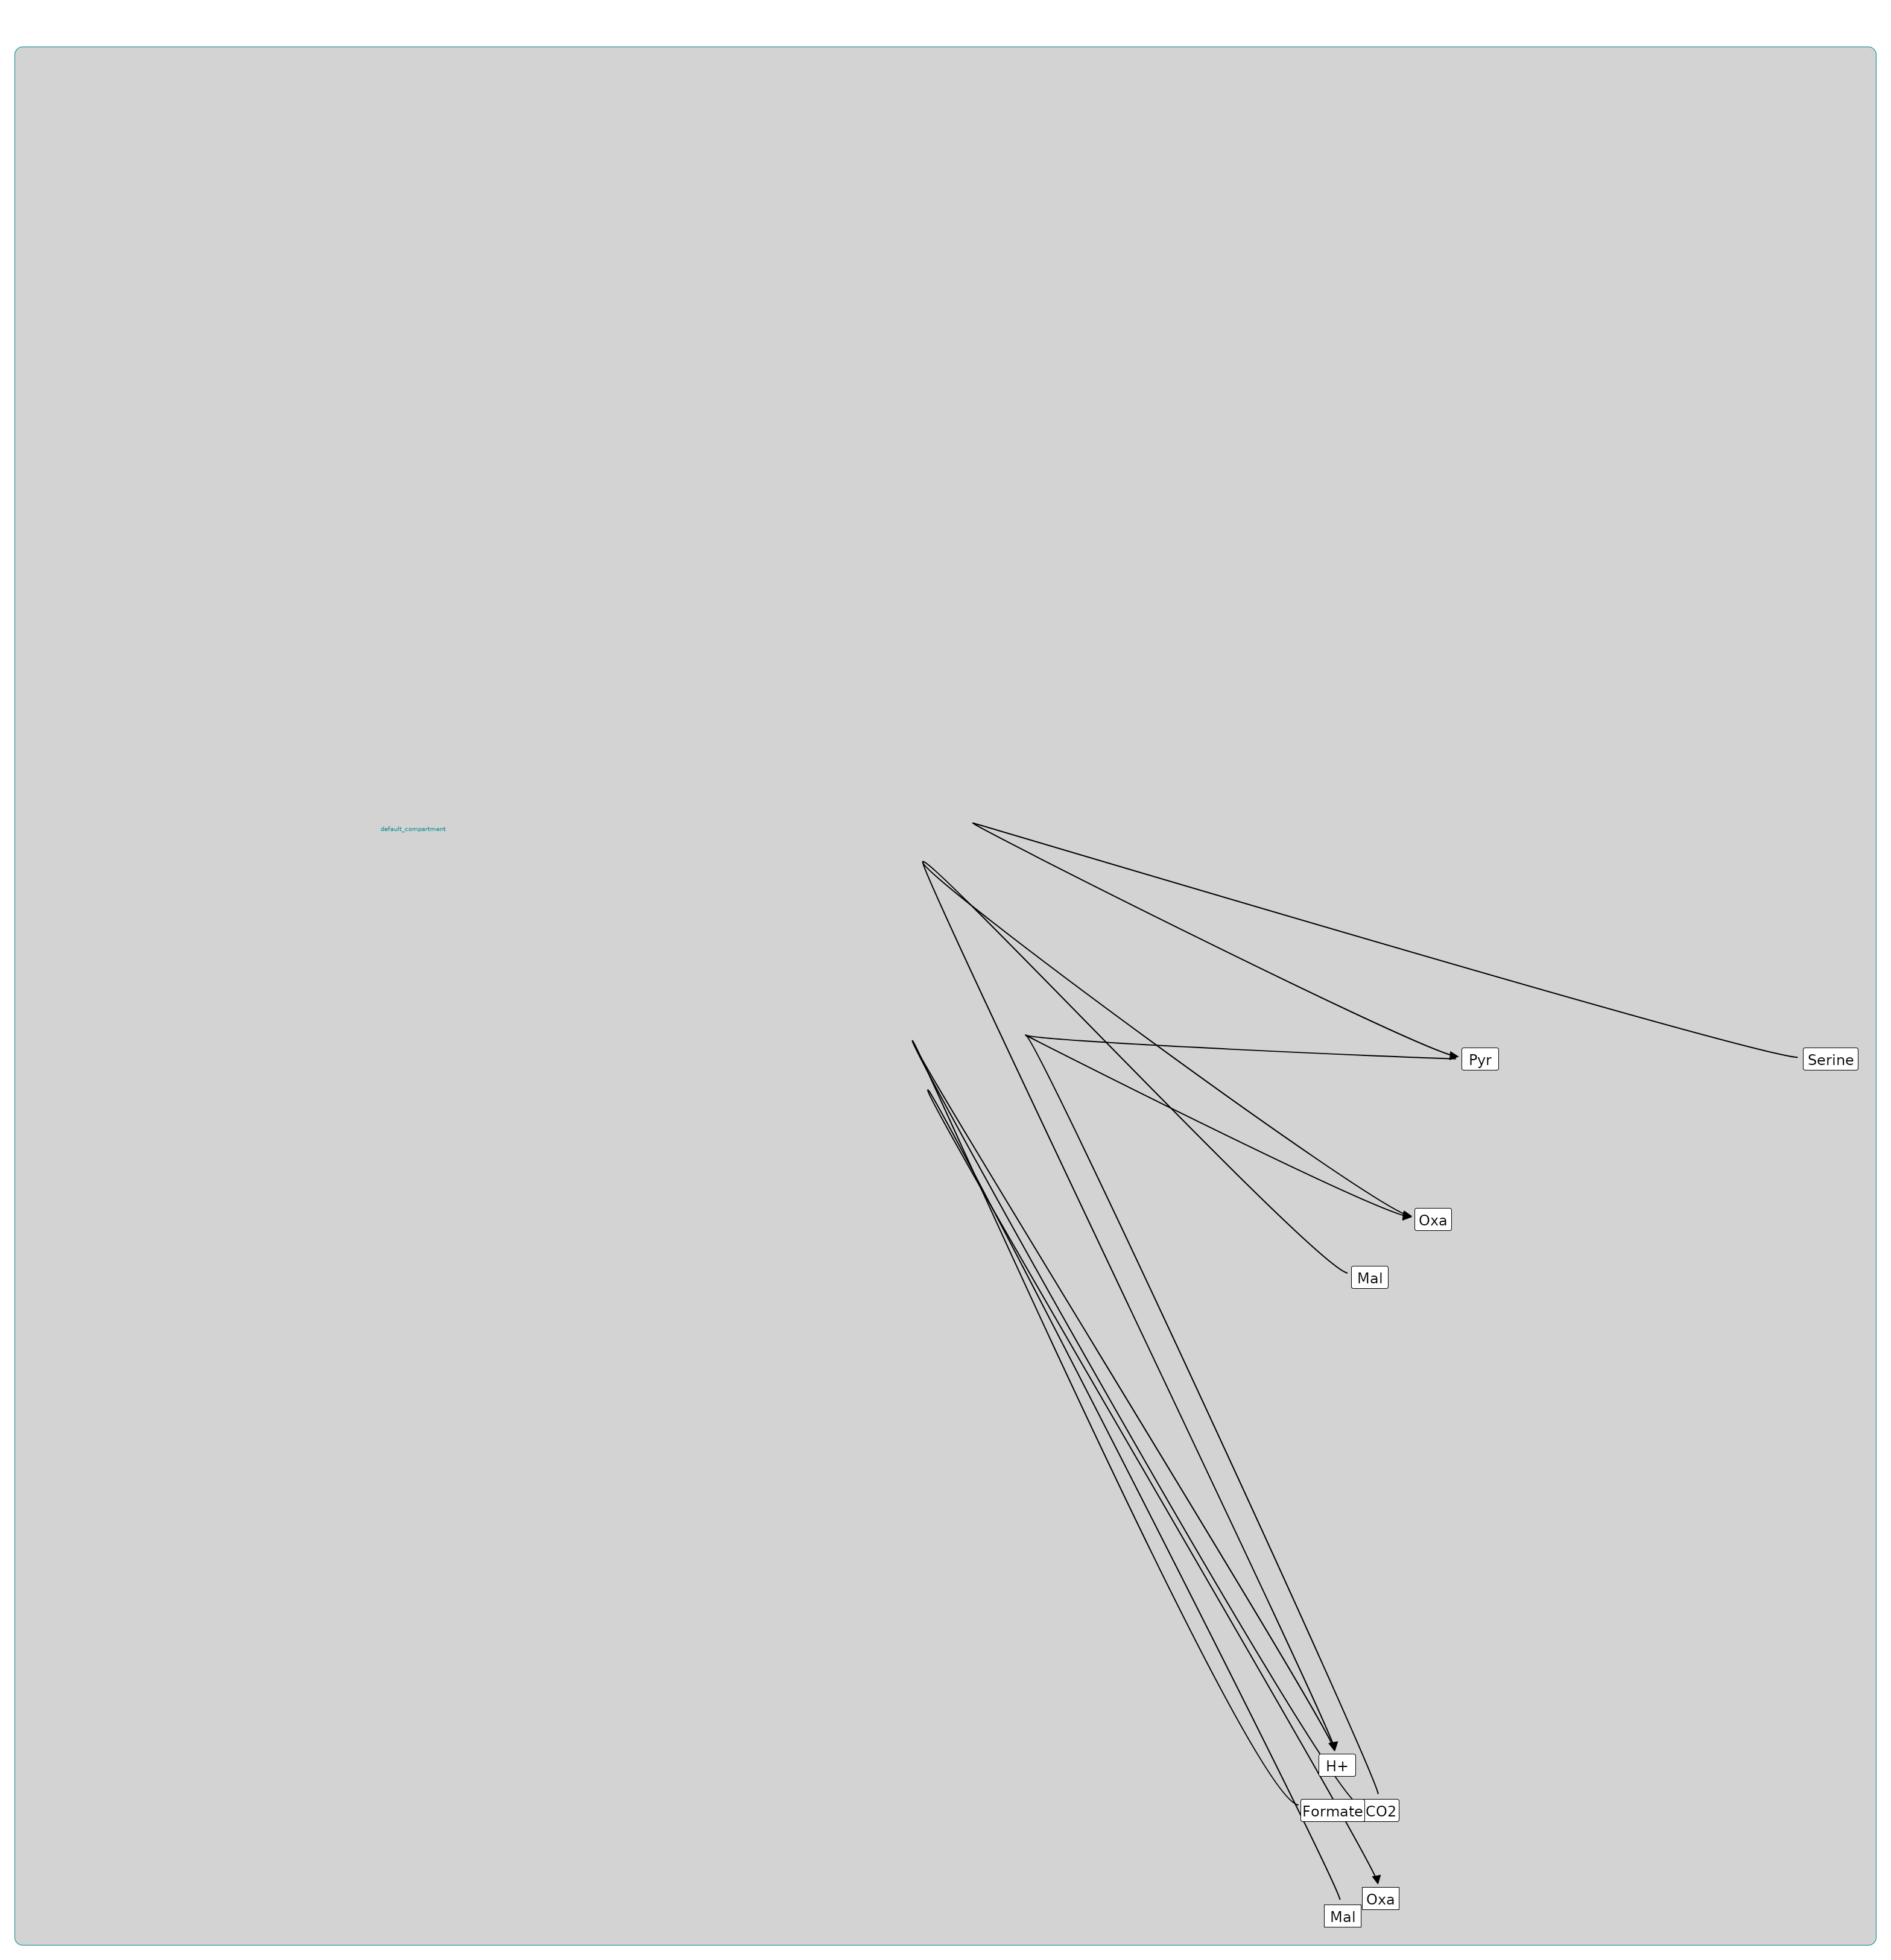

In [16]:
M0.draw()

In [ ]:
import matplotlib.pyplot as plt

# Your dictionary of coordinates
coordinates = cpd_coordinates_map_tran

# Create the plot
plt.figure(figsize=(12, 8))

# Plot points and add labels
for key, (x, y) in coordinates.items():
    label = key.split('_')[0]  # Extract the first element of the key
    plt.scatter(x, y, c='blue')  # Plot the point
    plt.text(x, y, label, fontsize=8, ha='right', va='bottom')  # Add the label

# Invert the Y-axis for drawing coordinates
plt.gca().invert_yaxis()

# Add labels and title
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Coordinate Plot with Labels')

# Display the grid and show the plot
plt.grid(True)
plt.show()

## IGNORE FROM HERE ON
## Colorbar

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

In [ ]:
r = te.loads('/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0_renamed.sbml')

In [ ]:
def get_color_from_gradient(value, min_val, max_val):
    # Normalize the value within the range
    norm = (value - min_val) / (max_val - min_val)
    # Use the color map 'coolwarm' from matplotlib
    cmap = plt.get_cmap('coolwarm')
    # Get the color in RGBA format
    rgba_color = cmap(norm)
    # Convert RGBA to HEX
    hex_color = mcolors.to_hex(rgba_color)
    return hex_color

In [ ]:
def colorByFlux(model, sbml, time, cmap='coolwarm'):
    sbml.reset()
    sbml.simulate(0,time)
    rates = sbml.getReactionRates()

    maxrate = rates.max()
    minrate = rates.min()

    reaction_flux_dict = {reaction_id: get_color_from_gradient(rate, minrate, maxrate) for reaction_id, rate in zip(np.array(sbml.getReactionIds()), rates)}

    for rid in reaction_flux_dict.keys():
        model.setLineColor(rid, reaction_flux_dict[rid])

    return model

In [ ]:
colorByFlux(M0, r, 1800).draw()

### Messing with curves

In [17]:
rxns = [key.split('_')[-2:] for key in curveDict]
spc = [key.split('_')[0] for key in curveDict]
coords = [v for v in curveDict.values()]

In [27]:
counter = []

for index, rxn in enumerate(rxns):
    if rxns.count(rxn) == 2:
        # if we have never encountered this reaction and index before, we'll give it the start point
        if rxn not in counter:
            counter.append(rxn)
            reaction = rxn[0]
            xval = coords[index][0]
            yval = coords[index][1]
            reaction_index = rxn[1]
            print(f'setting start points with {reaction} with x and y of ({xval}, {yval}) and index of {reaction_index}')
            M0.setSpeciesReferenceCurveSegmentStartPointX(reaction, xval, int(reaction_index))
            M0.setSpeciesReferenceCurveSegmentStartPointY(reaction, yval, int(reaction_index))
            M0.setSpeciesReferenceCurveSegmentBasePoint1X(reaction, xval, int(reaction_index))
            M0.setSpeciesReferenceCurveSegmentBasePoint1Y(reaction, yval, int(reaction_index))
        
        # if we have encountered it before, we'll give it the end point
        else:
            reaction = rxn[0]
            xval = coords[index][0]
            yval = coords[index][1]
            reaction_index = rxn[1]
            print(f'setting end points with {reaction} with x and y of ({xval}, {yval}) and index of {reaction_index}')
            M0.setSpeciesReferenceCurveSegmentBasePoint2X(reaction, xval, int(reaction_index))
            M0.setSpeciesReferenceCurveSegmentBasePoint2Y(reaction, yval, int(reaction_index))
            M0.setSpeciesReferenceCurveSegmentEndPointX(reaction, xval, int(reaction_index))
            M0.setSpeciesReferenceCurveSegmentEndPointY(reaction, yval, int(reaction_index))


setting start points with R406 with x and y of (2965.0, 1713.0) and index of 0
setting end points with R406 with x and y of (2399.0, 1713.0) and index of 0
setting start points with R269 with x and y of (2216.0, 2075.0) and index of 0
setting start points with R269 with x and y of (2171.0, 3134.0) and index of 1
setting end points with R269 with x and y of (2321.0, 1979.0) and index of 0
setting end points with R269 with x and y of (2234.0, 3105.0) and index of 1
setting start points with R345 with x and y of (2399.0, 1713.0) and index of 0
setting end points with R345 with x and y of (2321.0, 1979.0) and index of 0


In [1]:
M0.draw()

NameError: name 'M0' is not defined